# Before you start: Install Tensorflow and Keras

This assignment requires to install Keras. Using Anaconda, this should be simple:

`conda install keras`

That's it. If you get any conda package conflits, it may be convenient to create a new conda environment:

`conda create -n tf2 tensorflow=2.3.0 jupyter python=3.7 matplotlib seaborn scikit-learn`

This will create a conda environment with the name `tf2` and install tensorflow 2 (including Keras), jupyter notebook, matplotlib, seaborn and python 3.7. You can switch to the newly created `tf2` environment by typing

`source activate tf2` 

And then run

`jupyter notebook`

in the same terminal to open a jupyter notebook. 

_Note that after performing the install, you need to restart this notebook for the changes to take effect._

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)
print(keras.__version__)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Keras imports
from tensorflow.keras import backend as K
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D

2.1.0
2.2.4-tf


In [2]:
def prepare_data(use_classes = [0,8], return_shape_y='matrix',return_shape_x='flat',n_trainex_per_class='all'):
    '''Wrapper function that returns preprocessed training and validation data from the famous MNIST data set
    
    Note: Class labels are _always_ re-assigned such that the class labels returned are in range 0:n_classes 
    (i.e. if you request classes 2 and 8, you will still get labels 0 and 1 out)
    
    input arguments:
        use_classes: list of integers (values from 0-9 in any order)
        Only examples from the classes in this list will be returned
        
        return_shape_y: string ('matrix' or 'vector')
        'matrix' will return a one-hot class encoding of the labels with shape (n_examples x n_classes)
        'vector' will return a list of labels with length (n_examples)
        
        return_shape_x: string ('flat', 'channels' or 'image')
        'flat' will return input images as flattened arrays (n_examples x n_pixels)
        'image' will return input images as stacked images (n_examples x n_rows x n_columns)
        'channels' will return input images as stacked images with an additional channel dimension that tensorflow requires for convolutions
        shape for 'channels' will be either (n_examples x n_rows x n_columns x 1) or (n_examples x 1 x n_rows x n_columns), depending on your keras system settings
        
        n_trainex_per_class: int (values up to 5421 will work (5421 = number of example in smallest class))
        
        
    returns:
        (x_train, y_train): tuple of arrays
            x_train: training set images with shape defined by return_shape_x
            y_train: training set labels with shape defined by return_shape_y
        
        (x_test, y_test): tuple of arrays
            x_test: test set images with shape defined by return_shape_x
            y_test: test set labels with shape defined by return_shape_y
        
        num_classes: int
            number of classes used
        '''
    
    
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # input image dimensions
    img_rows, img_cols = 28, 28

    # find and use only examples of chosen classes
    train_idx = np.isin(y_train,use_classes)
    test_idx = np.isin(y_test,use_classes)
    x_train = x_train[train_idx,:,:]
    y_train = y_train[train_idx]
    x_test = x_test[test_idx,:,:]
    y_test = y_test[test_idx]
    
    # if required, use fewer training examples per class
    if not n_trainex_per_class=='all':
        y_smaller = []
        x_smaller = []
        for c in use_classes:
            class_idx = np.where(y_train==c)[0][:n_trainex_per_class]
            y_smaller.append(y_train[class_idx])
            x_smaller.append(x_train[class_idx,:,:])
        y_train = np.concatenate(y_smaller)
        x_train = np.concatenate(x_smaller)

    # make new class labels that are 0:n_classes (needed for later use of 'keras.utils.to_categorical')
    new_class_ids_mapping = {old_id:new_id for new_id,old_id in enumerate(use_classes)}
    num_classes = len(use_classes)
    y_test = np.array([new_class_ids_mapping[y] for y in y_test])
    y_train = np.array([new_class_ids_mapping[y] for y in y_train])

    # normalize images and print shape
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    # if requested convert class vectors to binary class matrices
    if return_shape_y=='matrix':
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)
    # otherwise return as vector
    elif return_shape_y=='vector':
        pass
    else:        
        raise Exception('unknown return_shape_y')
    
    if return_shape_x=='flat':
        # flatten image data
        x_train = x_train.reshape(len(y_train), img_rows*img_cols)
        x_test = x_test.reshape(len(y_test), img_rows*img_cols)

    elif return_shape_x =='channels':
        # reshape to add channel dimension (being aware of the keras system setting)
        if K.image_data_format() == 'channels_first':
            x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
            x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
            x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)
    elif return_shape_x == 'image':
        pass
    
    else:
        raise Exception('unknown return_shape_x')

    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('x_train shape:', x_train.shape)
    print('y_train shape:', y_train.shape)
        
    return (x_train, y_train), (x_test, y_test), num_classes

# Task 0: Explore the dataset

We load the full MNIST dataset as provided by `tensorflow.keras.datasets.mnist` and plot 10 examples of each class in a 10x10 plot. 

In [3]:
# load data
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes=list(range(10)),return_shape_y='vector',return_shape_x='image',n_trainex_per_class=10)

100 train samples
10000 test samples
x_train shape: (100, 28, 28)
y_train shape: (100,)


In [4]:
# for later use
n_rows = x_train.shape[1]
n_clms = x_train.shape[2]

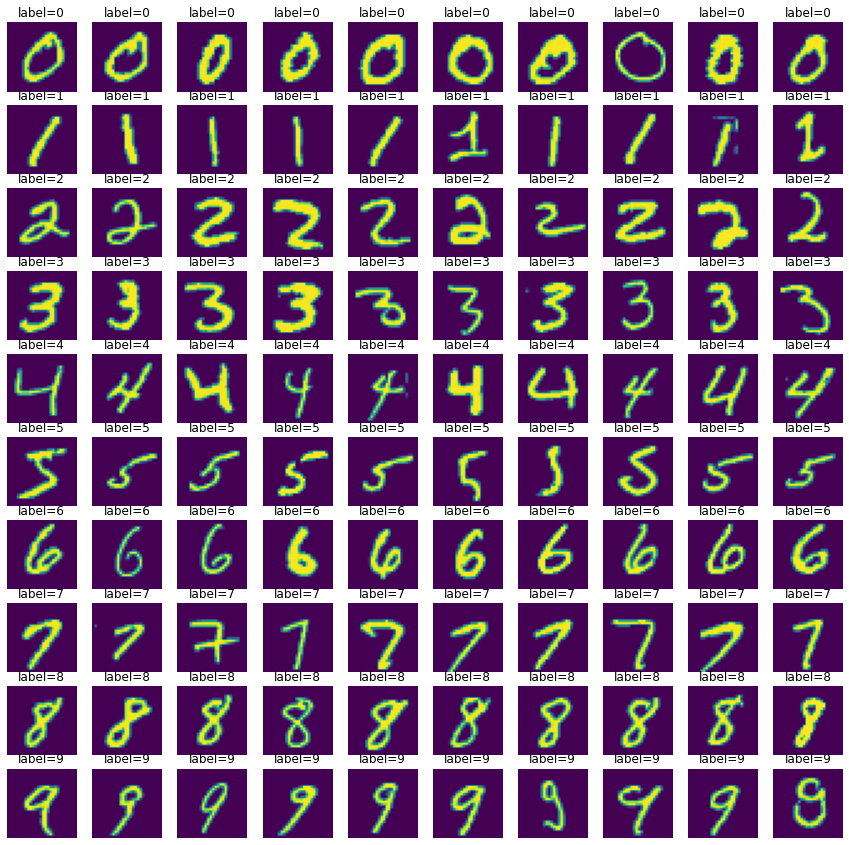

In [5]:
# display the first few examples
fig,axes = plt.subplots(10,10,figsize=(15,15))
axes=axes.flatten()
for i,ax in enumerate(axes):
    
    ax.imshow(x_train[i,:,:])
    ax.set_title('label=%u' % (y_train[i]))
    sns.despine()
    ax.axis('off')
plt.show()

# Task 1: LDA (15 points)

For the rest of the notebook, we will restrict ourselves to the classes `3` and `8`, and also to a subset of examples (`500` per class).

First, use Linear Discriminant Analysis to separate the classes. Here you will need to find a weight vector $\vec{w}$ so that the classes are optimally separated in the projections $p_i =   \vec{w}^T \vec{x}_i$ of data points $\vec{x}_i$.

In [34]:
classes = [3,8]
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes = classes,return_shape_y='vector',return_shape_x='flat',n_trainex_per_class=500)

1000 train samples
1984 test samples
x_train shape: (1000, 784)
y_train shape: (1000,)


Use the analytic solution to compute the optimal weights $\vec{w}$ from the training set data. 

Note: In cases like ours where $n_{features}$ isn't much smaller than $n_{samples}$, the within-class covariance matrix is not invertible. To fix this, we can add a small constant to the diagonal of it, which is equivalent to ridge regularization. Play a bit with the value of the pentaly to see its effect and find a value that gives good results.

You can rely on the fact that there is the same number of samples in each class (it simplifies some of the formulas).

In [35]:
def compute_lda_weights(x,y,alpha):
    '''function that computes regularized LDA weights for a two class problem
    
    input:
        x: training data -- array with shape (n_examples x n_features)
        y: training data class label -- flat array with length (n_examples)
        alpha: regularization strength -- float
        
    returns:
        m0: mean of the training examples of class 0 -- flat array with length (n_features)
        m1: mean of the training examples of class 1 -- flat array with length (n_features)
        mdiff: difference of the two class means -- flat array with length (n_features)
        w: regularized LDA weight vector -- flat array with length (n_features)
        '''
    
    # covariances per class
    cov0 = np.cov(x[y==0,:],rowvar=False)  
    cov1 = np.cov(x[y==1,:],rowvar=False)
    # means per class
    m0 = np.mean(x[y==0,:],axis=0)
    m1 = np.mean(x[y==1,:],axis=0)
    mdiff = m1-m0
    
    # invert within-class covariance matrix
    # add small constant variance to diagonal
    const = np.eye(n_rows*n_clms)*alpha
    S_within = cov0+cov1+const
    S_within_inv = np.linalg.inv(S_within)

    # get optimal projection vector w
    w = S_within_inv @ mdiff
    
    return m0,m1,mdiff,w

As  $\vec{w}$ has the dimensionality of our input data, we can interpret it as image with the same size as the training examples. Reshape the weight vector accordingly and plot the resulting 'weight image'. Describe and interpret the image.

In [36]:
def plot_weight_image(flat_data,im_dim,titlestr):
    '''Function that takes a flat vector with the same dimensionality as the input data 
    and plot it as an image of the shape of the original images'''
    
    # INSERT YOUR CODE HERE
    im_data = np.reshape(flat_data,im_dim) # reshape flat data to image dimensions
    plt.imshow(im_data) # plot the reshaped flat data
    plt.title('{title}' .format(title = titlestr)) # add the title string to the plot title


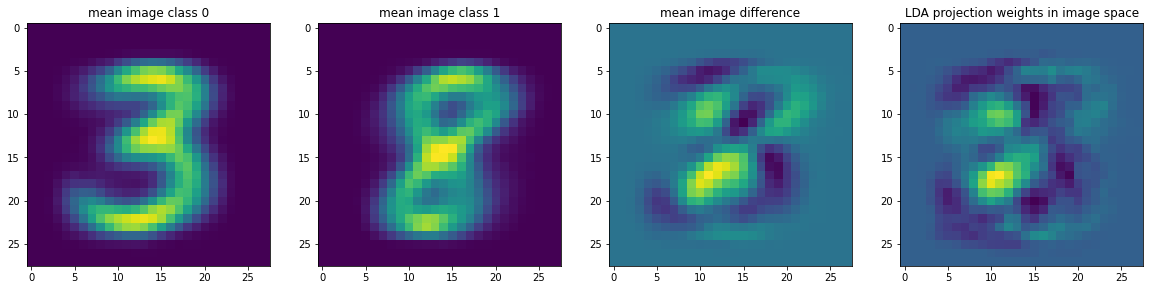

In [37]:
# compute weights
m0,m1,mdiff,w = compute_lda_weights(x_train,y_train,alpha=1.1)

# vizualize input data and resulting weight vector
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plot_weight_image(m0,(n_rows,n_clms),'mean image class 0')
plt.subplot(1,4,2)
plot_weight_image(m1,(n_rows,n_clms),'mean image class 1')
plt.subplot(1,4,3)
plot_weight_image(mdiff,(n_rows,n_clms),'mean image difference')
plt.subplot(1,4,4)
plot_weight_image(w,(n_rows,n_clms),'LDA projection weights in image space')
plt.show()

ADD YOUR ANSWER HERE:

1. The 'mean image class 0' contains the feature means of the number '3' and as a result we see an image of '3'.
2. Similarly the 'mean image class 1' contains the feature means of the number '8' and as a result we see an image of '8'.
3. 'mean image difference' contains the feature information of $m1-m0$. So, the common region in the image of $m1$ and $m2$ that contains same (or similar) pixel values appear green (or different shades of green depending on how similar the pixel values are). The color then gradually turns yellow as the pixel values for $m1$ becomes larger than $m0$, or black when the pixel values for $m0$ becomes larger than $m1$. So the black and yellow coloured patches in the 'mean image difference' plot could be seen as critical information for classification of the two classes. However, this information is dependent heavily on the shape of the numbers as the within class variances are not taken into account.
4. LDA projection weights take into account the within class variances that mean image difference failed to capture. So rather than naively looking at the difference of means, LDA also multiplies this difference by the inverse of the pooled covariance  and we see a more blurry image for the 'LDA projection weights in image space'. The image shows that some of the critical information from the 'mean image difference' plot is retained for classification and the within class variances have also been taken into account, resulting in finer shades of green in certain regions where the 'mean image difference' plot bore no information.

Here, it is important to note the penalty used for LDA weights. A penalty of $\alpha=1.1$ was used for the LDA weights computation above. It was seen that significantly small $\alpha$ resulted in high variance in the LDA weights projection image which could lead to overfitting. Whereas, for large $\alpha>2$ there was high bias which could result in underfitting. An $\alpha$ in the range of $(0.7,1.5)$ was determined to be better. Finally, after repeatedly looking at the plots as well as the training and test error $\alpha$ was fixed for LDA weights computation at $1.1$

Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. Is the separation good? Is there a big difference between training and test data?

In [38]:
# Compute the projections for training and test data


# INSERT YOUR CODE HERE 
# projections computed according to the mathematical definition of vector projection
# as the dot product of the training vector and weights vector divided by the norm of the weights vector.
x_train_proj = np.dot(x_train, w)/np.linalg.norm(w)
x_test_proj = np.dot(x_test, w)/np.linalg.norm(w) 


In [39]:
def projection_histogram(x_proj,y,titlestr='',threshold='none'):
    '''Function that projects data x on a LDA weight vector w and plots the projection values separately by class
    
        input:
        x_proj: input data -- flat array with length (n_examples)
        y: class labels -- flat array with length (n_examples)
        titlestr: histogram title string
        threshold: threshold value (float) or 'none' (string) to not plot a threshold
    '''
    
    # INSERT YOUR CODE HERE
    plt.style.use('seaborn-deep')
    bins = np.linspace(-6, 6, 50)
    
    index_0 = np.where(y==0) # select indices with class label '0'
    index_1 = np.where(y==1) # select indices with class label '1'
    # plot the histogram with labels, legend and title
    plt.hist(x_proj[index_0],bins,label = 'Class 0',alpha = 0.5)
    plt.hist(x_proj[index_1],bins,label = 'Class 1',alpha = 0.5)
    plt.legend(loc='upper right')
    plt.title('{title}' .format(title = titlestr))
    
    # case when threshold value is passed to the function
    if threshold != 'none':
        # plot the threshold
        plt.axvline(x=threshold,color='r', linestyle='--',label = 'Threshold, c = {}'.format(round(threshold,3)))
        plt.legend(loc='upper right')

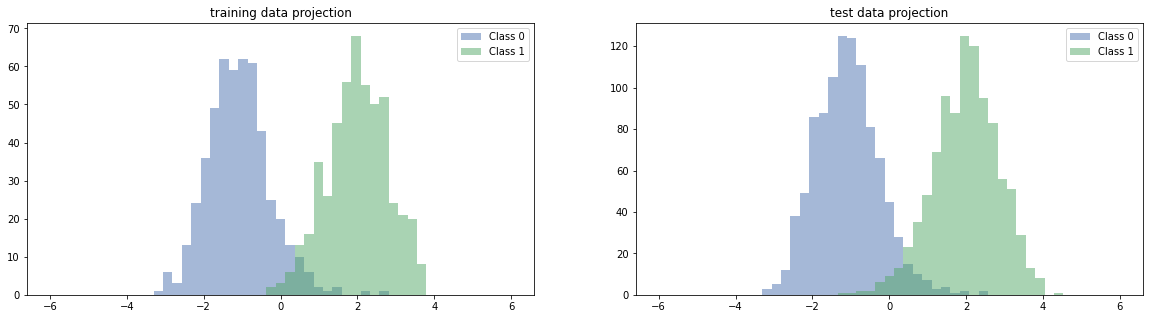

In [40]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
projection_histogram(x_train_proj,y_train,'training data projection')
plt.subplot(1,2,2)
projection_histogram(x_test_proj,y_test,'test data projection')
plt.show()

ADD YOU ANSWER HERE:


The training and test data were projected on $\vec w$ according to the mathematical definition of vector projections. So, $proj_{\vec w}{\vec x}=\frac{\vec w\bullet\vec x}{||w||}\vec w$.

The class separation in the two-color histogram looks good. The means of the two class distributions are spaced distinctly apart and the variances of the two distributions are small. 

There is no big difference between the training and test data projections. Their means are similarly spaced between classes with small variances. However, as the data is not truly Gaussian, LDA is not optimal and logistic regression would perform better


Now we make class predictions based on the projections. Compute the threshold $c$ for projected values $p_i$ based on the training data (assigning each point to the class with higher posterior probability; assuming balanced classes, that's the same as higher likelihood). Print the value of $c$ and plot $c$ into the histograms of projected values you made before. You can use the fact that the classes are balanced.

Use $c$ to assign class labels for training and test set. Determine the classification errors on both datasets and print them. 

In [13]:
def opt_c_LDA(m0,m1,w):
    '''Compute the optimal threshold for LDA 
    
    input:
        m0, m1: mean vectors of the two classes -- flat array with length (n_features)
        w: weight vector of LDA -- flat array with length (n_features)
        
    output:
        c: the optimal threshold for LDA
         
    '''
    
    # INSERT YOUR CODE HERE
    
    c = 0.5*np.dot((m0+m1),w)
    
    # For the two group case with equal priors things simplify, 
    # the weights vector is then proportional to Σ^−1(μ_2−μ_1), 
    # and the linear discriminator is given by taking inner product with w. 
    # In the case of equal prior probabilities (due to balanced classes) on the two groups,
    # we don't need to know the constant of proportionality
    # and the cutoff is 1/2(μ_0+μ_1)^T*w
    
    return c

In [14]:
def score_LDA(x_proj,y,c):
    '''Compute the optimal threshold for LDA and the return the error 
    based on thresholding projected values
    
    input:
        x_proj: projected data -- flat array with length (n_examples)    
        y: class labels -- flat array with length (n_examples)
        c: optimal threshold for LDA - scalar
        
    output:
        y_hat: class label predicitons of LDA model -- flat array with length (n_examples)
        error: classification error
        
    '''
    
    # INSERT YOUR CODE HERE
    y_hat = [] # create empty estimated class label vector
    n = np.shape(y)[0] # total instances
    
    # if projected x is less than or equal to optimal threshold then label as '0' else '1'
    for x in x_proj:
        if x<=c:
            y_hat.append(0)
        else:
            y_hat.append(1)
                
    error = np.sum(abs(y_hat-y))/n #classification error
    return y_hat, error

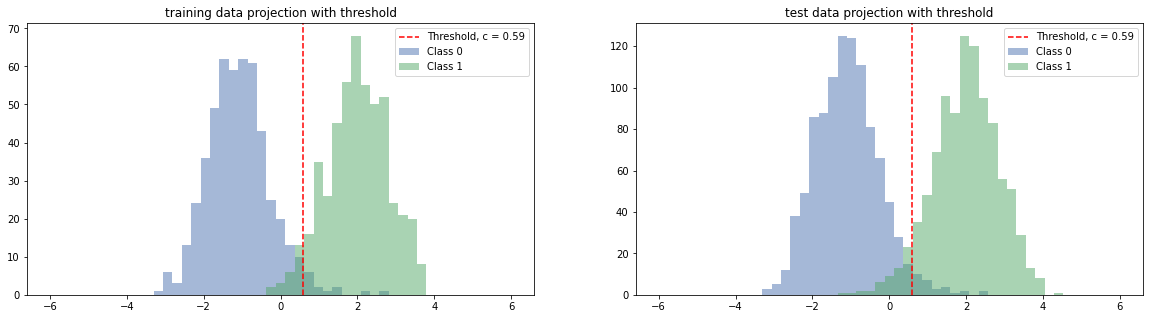

Training set error (LDA):  0.038
Test set error (LDA):      0.04233870967741935


In [15]:
c = opt_c_LDA(m0,m1,w)

y_hat_train, error_train = score_LDA(x_train_proj,y_train,c)
y_hat_test, error_test = score_LDA(x_test_proj,y_test,c)

# show threshold in histograms
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
projection_histogram(x_train_proj,y_train,'training data projection with threshold',c)
plt.subplot(1,2,2)
projection_histogram(x_test_proj,y_test,'test data projection with threshold',c)
plt.show()

# print training and test set accuracy
print("Training set error (LDA): ", error_train)
print("Test set error (LDA):     ", error_test)

## Task 2: MNIST with Logistic Regression (15 points)

Now we will use logistic regression, again using `sklearn`. To make sure results are comparable, set the parameters `random_state=1` and `solver='saga'` when you define the models. Also, if you get convergence warnings choose a larger `max_iter` until all your models converge. You should not need more than 5000 iterations. Use the `n_jobs` parameter to control multiprocessing behavior (this can give a good speed-up for the later parts of this task if you have multiple CPU cores).

### Unregularized logistic regression
First, fit an unregularized logistic regression model using `sklearn`'s `LogisticRegression()`, and use `sklearn`'s in-built scoring function to get a test set error.

In [16]:
# define model
# INSERT YOUR CODE HERE
logreg_base = LogisticRegression(penalty='none',random_state=1, solver = 'saga', max_iter = 5000)

# fit
# INSERT YOUR CODE HERE
logreg_base.fit(x_train, y_train)

# score
print("Test set error (LogReg - no regularization) :", 1 - logreg_base.score(x_test,y_test))

Test set error (LogReg - no regularization) : 0.05241935483870963


### Ridge and Lasso with CV
Next, we will use Lasso and Ridge regularized logistic regression

Use `sklearn`'s `LogisticRegressionCV()` model to run a 10-fold crossvalidation over ten different log-spaced regularization strengths to find an optimal regularization strength; do this for both Lasso and Ridge regularization. Hint: Watch out for the parametrisation `sklearn` uses to pass the regularization strength. Note that this can take a few minutes to run.

In [17]:
# set shared hyperparameters
n_folds = 10
n_alphas = 10
max_iter = 5000

# define models

# INSERT YOUR CODE HERE
from sklearn import linear_model

logreg_lasso_cv = LogisticRegressionCV(Cs = n_alphas, cv=n_folds, penalty='l1', solver = 'saga', fit_intercept= False, n_jobs=-1, random_state=1, max_iter = 5000)

logreg_ridge_cv = LogisticRegressionCV(Cs = n_alphas, cv=n_folds, penalty='l2', solver = 'saga', fit_intercept= False, n_jobs=-1, random_state=1, max_iter = 5000)



# fit models
logreg_lasso_cv.fit(x_train, y_train)
logreg_ridge_cv.fit(x_train, y_train)



# INSERT YOUR CODE HERE

LogisticRegressionCV(cv=10, fit_intercept=False, max_iter=5000, n_jobs=-1,
                     random_state=1, solver='saga')

Plot crossvalidation curves for both lasso and ridge regularized logisitic regression: Plot regularization strength $\alpha$ vs. accuracy for each fold. Indicate the average accuracy across folds and mark the average score with optimal $\alpha$. In the code below, we already convert the sklearn parametrization of the regularization strength to a standard format.

In [18]:
def plot_cv_curves(alphas, cv_scores):
    '''Function that plots CV results: data from each fold/alpha combination,
    average over fold and a special mark for the optimal alpha.
    
    inputs: 
        alphas - flat array with alphas used in the CV, length (n_alphas)
        cv_scores - array accuracy values for each score/alpha combination, shape (n_folds x n_alphas)
    '''
    
    # INSERT YOUR CODE HERE
    m, n = np.shape(cv_scores) # shape of cv_scores
    mean_acc = np.mean(cv_scores, axis = 0) # average cv_scores across folds
    opt_cv_score = mean_acc.max() # optimal cv_score
    opt_alpha = alphas[np.where(mean_acc == opt_cv_score)].max() # alpha corresponding to optimal cv_score
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    
    # make the plots
    for i in range(m):
        # plot alpha vs cv_scores
        plt.plot(alphas,cv_scores[i], color = colors[i], label='Fold %s' % (i+1))
        # plot average cv_scores
        plt.plot(alphas[i],mean_acc[i],'o', color = colors[i])
        plt.plot()
        plt.xscale('log')
        plt.xlabel('Regularization strength alpha')
        plt.ylabel('Per fold accuracy')
    # plot best cv_score
    plt.plot(opt_alpha,opt_cv_score,color= 'black',marker=".", markersize=20,label='Best Score')
    plt.legend(loc = 'best')
    # print the optimal alpha and best accuracy pair
    print('The optimal alpha and CV_score pair is: ({}, {})'.format(opt_alpha, opt_cv_score))
        


The optimal alpha and CV_score pair is: (0.0007742636826811277, 0.9499999999999998)
The optimal alpha and CV_score pair is: (2.782559402207126, 0.961)


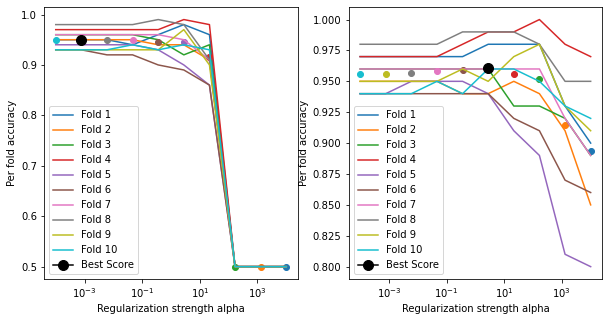

In [19]:
alphas_lasso = 1/logreg_lasso_cv.Cs_
alphas_ridge = 1/logreg_ridge_cv.Cs_
cv_scores_lasso = logreg_lasso_cv.scores_[1]
cv_scores_ridge = logreg_ridge_cv.scores_[1]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_cv_curves(alphas_lasso,cv_scores_lasso)
plt.subplot(1,2,2)
plot_cv_curves(alphas_ridge,cv_scores_ridge)
plt.show()

For both Lasso and Ridge, show how the 'weight images' change as a function of regularization strength. Plot one weight image per regularization strength value. Use `plt.colorbar()` to show the color-value mapping next to each plot so you can also see if the range of values changes. Describe and interpret what you observe.

In [20]:
def plot_weight_image_evolution(alphas,coefs_paths):
    '''function that plots weight image change with alphas'''

    fig,axes=plt.subplots(2,np.ceil(len(alphas)/2).astype(int),figsize=(15,5))

    # INSERT YOUR CODE HERE
    
    # iterate over axes
    for i, ax in enumerate(axes.ravel()):
        # select the flat_data per alpha using fold 10
        pic = coefs_paths[9][i]
        # reshape flat_data to image data and plot
        im_data = np.reshape(pic,(int(np.sqrt(pic.shape[0])),int(np.sqrt(pic.shape[0]))))
        ax.imshow(im_data)
        pos = ax.imshow(im_data, interpolation='none')
        plt.colorbar(pos, ax=ax)
        ax.set_title('alpha ={title}' .format(title = round(alphas[i],4)),fontsize=10)
        
    plt.tight_layout()


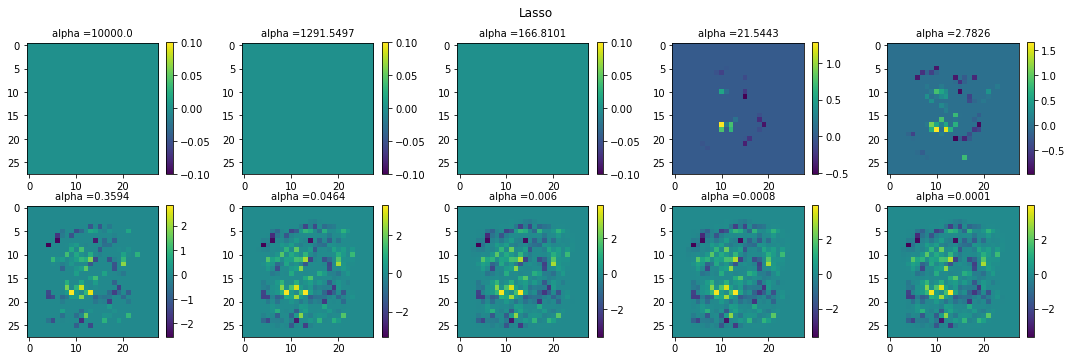

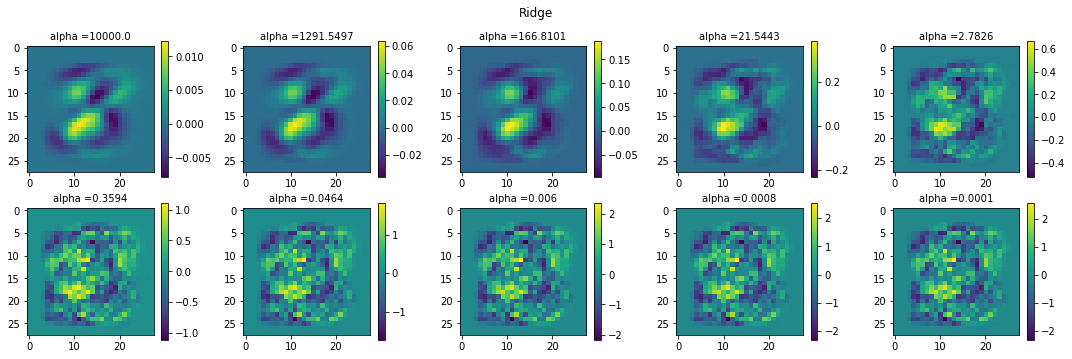

In [21]:
plot_weight_image_evolution(alphas_lasso,logreg_lasso_cv.coefs_paths_[1])
plt.suptitle('Lasso')
plt.tight_layout()
plt.show()

plot_weight_image_evolution(alphas_ridge,logreg_ridge_cv.coefs_paths_[1])
plt.suptitle('Ridge')
plt.tight_layout()
plt.show()

YOUR ANSWER HERE

1. For Lasso weight images: We see that for large regularization strength, $\alpha>20$, the weight images do not contain important feature information for classification of data (as in the first 3 images under Lasso). This is due to the nature of Lasso regularization where for large $\alpha$ the Lasso algorithm forces the coefficients to be zero. The coefficients then start taking non-zero values as the regularization strength decreases with critical feature information starting to show for $\alpha<0.4$. As $\alpha$ decreases further, the effect of within class variances becomes increasingly prominent and the weight images become more pixelated and blurry. This behavior can be inferred from the color mapping values as well. When $\alpha>20$ the range of color values was $(-0.1,0.1)$ which increased to $(-0.5,1.5)$ for $0.3<\alpha<20$. Finally, in a more feasible range of $\alpha$,the range of color mapped values increased to $(-3,3)$.


2. For Ridge weight images: Observation similar to that of Lasso weight images can be made in this case as well. One clear distinction with the lasso weight images is the plot of the first three weight images for large $\alpha$ in the case of ridge. Unlike lasso regulariation, ridge regularization does not set coefficients to zero for large penalties. Rather the coefficients slowly converge to zero. As such, in our plot for $10000<\alpha<21$ there are small non-zero coefficients with approximate range of color mapped values $(-0.05,0.15)$ and we see a blurry weight image. This looks similar to the mean-difference weight image from LDA. In the case of LDA where $n_{features}=784$  wasn't much smaller than  $n_{samples}=1000$ , to address the non-invertibility of the within-class covariance matrix we added a small constant to the diagonal of the pooled covariance matrix. This  was equivalent to ridge regularization with a strong penalty where small within class variances were no longer significant. On reducing the regularization strength further, the effect of the within class variance was captured and the range of color mapped values increased. For very small $\alpha$, there is very high variance in the weight images, indicating a possible overfitting of the data.


3. It is evident that the ridge regularization weight images captured more relevant feature information as compared to the lasso regularized weight images.


4. With some intuition from looking at the weight image evolutions, it can be commented that lasso regularized logistic regression would require much small regularization strength than ridge regularized logistic regression.


5. The plot of 'cv_scores' reflect our intuition in point 4 and give us $\alpha_l=0.008$ and $\alpha_r=2.783$.

Compare the test error of the best lasso regularized logistic regression, the best ridge regularized logistic regression and the unregularized model.


In [22]:
print("Test set error (LogReg - no regularization) :", 1 - logreg_base.score(x_test,y_test))
print("Test set error (LogReg - ridge) :", 1 - logreg_ridge_cv.score(x_test,y_test))
print("Test set error (LogReg - lasso) :", 1 - logreg_lasso_cv.score(x_test,y_test))

Test set error (LogReg - no regularization) : 0.05241935483870963
Test set error (LogReg - ridge) : 0.04233870967741937
Test set error (LogReg - lasso) : 0.05947580645161288


Plot 'weight images' of the best lasso regularized logistic regression, the best ridge regularized logistic regression and the unregularized model. Describe and interpret the differences you observe. Also compare to the weight image obtained with LDA!

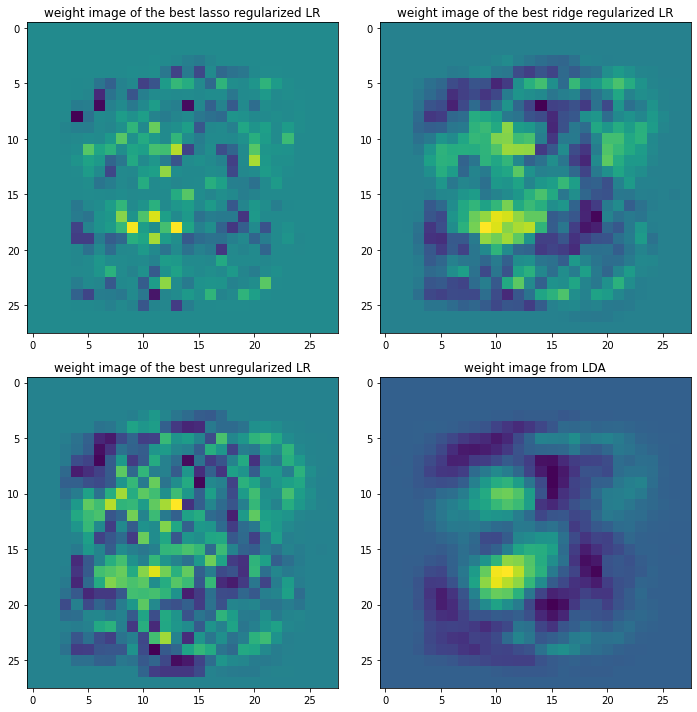

In [23]:
plt.figure(figsize=(10,10))

# INSERT YOUR CODE HERE
im_dim = (28,28) # input image dimensions

# a function that return the index of alpha corresponding to the optimal cv_score
# takes a vector of alphas and cv_scores as input
def optimal_key(alphas,cv_scores):
    m, n = np.shape(cv_scores) # shape of cv_scores
    mean_acc = np.mean(cv_scores, axis = 0) # average cv_scores across folds
    opt_cv_score = mean_acc.max() # optimal cv_score
    opt_alpha = alphas[np.where(mean_acc == opt_cv_score)].max() # alpha corresponding to optimal cv_score
    key = np.where(alphas == opt_alpha) # finds the index
    return key

# for lasso
key_lasso = optimal_key(alphas_lasso,cv_scores_lasso) # index of best alpha for lasso
flat_data_lasso = logreg_lasso_cv.coefs_paths_[1][9][key_lasso] # flat weight image data for best lasso
plt.subplot(2,2,1)
plot_weight_image(flat_data_lasso,im_dim,'weight image of the best lasso regularized LR')

# for ridge
key_ridge = optimal_key(alphas_ridge,cv_scores_ridge) # index of best alpha for ridge
flat_data_ridge = logreg_ridge_cv.coefs_paths_[1][9][key_ridge] # flat weight image data for best ridge
plt.subplot(2,2,2)
plot_weight_image(flat_data_ridge,im_dim,'weight image of the best ridge regularized LR')

# for unregularized
plt.subplot(2,2,3)
plot_weight_image(logreg_base.coef_,im_dim,'weight image of the best unregularized LR')

# for LDA
plt.subplot(2,2,4)
plot_weight_image(w,(n_rows,n_clms),'weight image from LDA')

plt.tight_layout()
plt.show()

YOUR ANSWER HERE


Performance of the models in terms of the test set error can be ordered as below:
1. Ridge regularized logistic regression: Test set error = 0.0423387096774193
2. LDA: Test set error = 0.0423387096774193
3. Unregularized logistic regression: Test set error = 0.05241935483870963
4. Lasso regularized logistic regression: Test set error = 0.05947580645161288

Starting with the lowest performing model, the weight image of the best lasso regularized LR clearly contains the least number of critical points for classification (as seen by the amount of color mapped values approximately equal to 3 or -1 corresponding to yellow or black). This is again a consequence of the nature of regularization done by lasso as previously discussed.


For second worst model, the weight image of the best unregularized LR captures too many critical points for classification. The image has too many sharp and distinctly shaded color squares meaning that the model does not account for any within class variance and treats every feature important. This will lead to overfitting.

The LDA model (second best model) addresses the overfitting concerns in the best unregularized LR model by addition of a small constant to the diagonal of the pooled covariance matrix, thereby, behaving similar to the Ridge regularized logistic regression model. So the shades of colors in its weight matrix are smoother than that of the best unreg LR. But as the data is not perfectly Gaussian, so the best model in our case is the Ridge regularized logistic regression with $\alpha = 2.783$. The weight image of the best ridge regularized LR contains several critical feature information for classification (in yellow and black pathces) as well as accounts for the within-class variance with smoother color shading. 

A note here is that, our choice of $\alpha$ for LDA gives us a test error same with that of the ridge regularized LR model upto 16 significant digits. We awarded the Ridge regularized LR model the best model in this case just due to the fact that our data might not be truly Gaussian.

## Task 3: MNIST with simple Keras Fully connected neural network  (10 points)

Now we use the Keras library that provides easy access to custom neural network implementation. If you look for a tutorial, try this:

https://keras.io/getting-started/sequential-model-guide/

In the two Keras tasks (Task 3 & 4), your job is to play with the hyperparameters and find an architecture that works and, in the best case, outperforms the more simple models from before that reached about 95% test set performance.

We start with a fully connected network - which is basically a logistic regression, with an added layers of hidden units.

In [24]:
# loading the data in a format suitable for Keras and fully connected networks (flat inputs)
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes = classes,return_shape_x='flat',return_shape_y='matrix',n_trainex_per_class=500)

1000 train samples
1984 test samples
x_train shape: (1000, 784)
y_train shape: (1000, 2)


Create a Keras model with two fully connected layers that takes our (flattened) images as input and outputs a softmax class score for both classes. Use `.summary()` to display the model's structure.

You can experiment with different sizes of the hidden layers, and you can also experiment with adding Dropout layers if you want (this was not covered in the lecture, so is strictly optional).

In [25]:
# hyperparameter
n_hidden_units = 128
# dropout_strength = 0.2

# define model
# INSERT YOUR CODE HERE
model_fcn = Sequential()
model_fcn.add(Dense(n_hidden_units, input_shape=(784,), activation='relu'))                          
model_fcn.add(Dropout(0.2))

model_fcn.add(Dense(n_hidden_units, activation='relu'))    
model_fcn.add(Dropout(0.2))

model_fcn.add(Dense(2,activation='softmax'))


# print model structure
model_fcn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 117,250
Trainable params: 117,250
Non-trainable params: 0
_________________________________________________________________


Set up the model optimization with `compile()`: use stochastic gradient descent (`SGD()`) with default settings (but you can also try adaptive optimizers, such as `Adam()` if you want). Use a crossentropy loss. Make sure Keras saves the `accuracy` metric for each epoch of the optimization.

Train the network on the training set for 100 epochs, and specify the test set as  `validation_data` in your call to `.fit()`. Make sure you save the output of `.fit()` to a variable.

In [26]:
# hyperparameters
batch_size = 128
epochs = 100


# choose loss and optimzer
# INSERT YOUR CODE HERE
model_fcn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# fit model, return training history
# INSERT YOUR CODE HERE
history_fcn = model_fcn.fit(x_train, y_train, batch_size=128, epochs=100, verbose=0, validation_data=(x_test, y_test))

Report the test set error and loss.

In [27]:
# get final testset evaluation
# INSERT YOUR CODE HERE
score = model_fcn.evaluate(x_test, y_test, verbose=2) # using verbose=2 to check final accuracy

print("Test set error (Dense NN):", 1 - score[1])
print("Test set loss (Dense NN): ", score[0])

1984/1984 - 0s - loss: 0.1045 - accuracy: 0.9682
Test set error (Dense NN): 0.0317540168762207
Test set loss (Dense NN):  0.10454650852085662


Plot the trajectories of loss and accuracy for both test and training set, using the `history` object that `.fit()` returns. Describe how test and training loss behave over epochs. What do you observe and why?

In [28]:
def plot_history(history):
    '''Takes the history object returned by Keras' ´.fit()´ function and
    plots loss and accuracy curves for both training and validation set '''

     # INSERT YOUR CODE HERE
    fig = plt.figure()
    
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    

    plt.tight_layout()

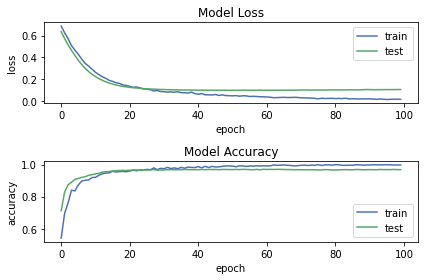

In [29]:
plot_history(history_fcn)

YOUR ANSWER HERE: 

This learning curve looks good. We see that the loss on the training set is decreasing rapidly for the first 20 epochs. This shows the network is quickly learning to classify the two digits. For the test set the loss initially decreases almost as fast as that of the training set but not as low as that of the training set. Overall test set loss stays roughly within the same range as the training loss. Similar comments can be made about the model accuracy (1-loss). Training accuracy increases rapidly within the first 10 epochs and reaches maximum accuracy of 1.0. Test set accuracy is about 0.7 initially but increases rapidly during the first 5 epochs to almost 0.9. Then after some slow increase, it steadies at about 0.968. This means that our model generalizes well to unseen data.

## Task 4: MNIST with simple Keras CNN  (10 points)

In [30]:
# load the data in a conv net & keras friendly format
(x_train, y_train), (x_test, y_test), num_classes = prepare_data(use_classes = classes,return_shape_x='channels',return_shape_y='matrix',n_trainex_per_class=500)

1000 train samples
1984 test samples
x_train shape: (1000, 28, 28, 1)
y_train shape: (1000, 2)


We defined a Keras model with convolutional layers and a fully connected top layer that outputs a softmax class score for both classes. Note that some of the parameters used below (number of hidden neurons, number of features, kernel size, etc) are not very good. Modify the existing network to obtain better results. Use `.summary()` to display the model's structure. Play with the hyperparameters such that you get roughly the same number of parameters as in the fully connected network above.

In [31]:
# hyperparameters
input_shape = x_train.shape[1:]
n_features_conv1 = 64
n_features_conv2 = 32
n_features_top = 128
kernel_size = 3
pool_size = 2
num_classes = 2

#define model
model_cnn = Sequential()
model_cnn.add(Conv2D(n_features_conv1, kernel_size=(kernel_size, kernel_size),
                 activation='relu',
                 input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model_cnn.add(Conv2D(n_features_conv2, (kernel_size, kernel_size), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(pool_size, pool_size)))


model_cnn.add(Flatten())
model_cnn.add(Dense(n_features_top, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(num_classes, activation='softmax'))

# show model structure
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               102528    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

Configure the optimization as in Task 3 and train for 100 epochs as in Task 3.

In [32]:
batch_size = 128
epochs = 100

# choose loss and optimizer
# INSERT YOUR CODE HERE
opt = Adam(lr=0.0001)
model_cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# fit model and return history
# INSERT YOUR CODE HERE
history_cnn = model_cnn.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test), verbose=0)

As in Task 3, print test set loss and error and plot the trajectories of loss and accuracy for training and test set. Discuss the differences and similarities to the fully connected model. What is the best model over everything?

1984/1984 - 0s - loss: 0.0330 - accuracy: 0.9889
Test set error (Conv NN): 0.011088728904724121
Test set loss (Conv NN):  0.033029163960764565


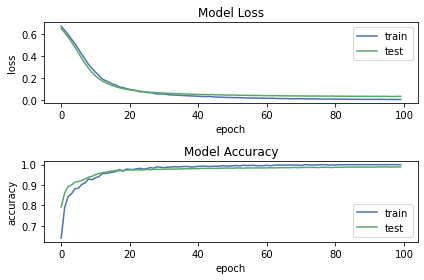

In [33]:
 # INSERT YOUR CODE HERE
score = model_cnn.evaluate(x_test, y_test, verbose=2)

print("Test set error (Conv NN):", 1 - score[1])
print("Test set loss (Conv NN): ", score[0])

plot_history(history_cnn)

As in Task 3, plot the trajectories of loss and accuracy for training and test set. Discuss the differences and similarities to the fully connected model. What is the best model over everything?

YOUR ANSWER HERE

As in the simple fully connected neural network, this learning curve also looks very good. We see that the loss on the training set is decreasing rapidly for the first 20 epochs indicating the network's ability to quickly learn to classify the two digits. For the test set, the loss decreases almost as fast as that of the training set and overall test set loss stays very close to that of the training loss. Similar comments can be made about the model accuracy (1-loss). Training accuracy increases rapidly within the first 5 epochs and reaches maximum accuracy of 1.0 after 40 epochs. Test set accuracy is close to 0.8 initially and slowly increases over 40 epochs to steady around 0.9889. This means our CNN model can very well classify the unseen data.

In both CNN and FCN, the evolution of loss and accuracy were similar. Both models learnt to classify very fast, achieving over $90\%$ accuracy within 20 epochs. However, as the CNN model is a deeper neural net and captures relevant feature information before the first dense layer using the convolution layers, it achieves higher overall accuracy than FCN. The difference between test/training set loss as well as test/training set accuracy is smaller for the CNN. So, keeping in view that both models share almost same number of paramters and use the same loss function and optimizer, the Convolutional Neural Network is the best model.


An important note here could be that addition of too many hidden layers could have adverse affect in classification and lead to overfitting. Also, adding too many neurons per layer could also cause problems as we should go deep in the neural network and not wide. Both the number of hidden layers and the size of the hidden layers contribute to the number of parameters to be estimated. In our case with only $1000$ training samples and $764$ features per sample, a million parameters in the neural network model might be prone to overfitting. Although there is not an exact answer for the optimum number of paramters at the moment, it seems that any number of parameters in the range of 100,000-200,000 should suffice.